In [1]:
import numpy as np
import cv2
from pathlib import Path
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from descriptor_index_pb2 import DescriptorIndex
from debug_fusion_pb2 import DebugFusion
from utils import plot_imgs, draw_matches
%load_ext autoreload
%autoreload 2

INDEX_ROOT = '../deep-relocalization/data/'
MAP_ROOT = '../deep-relocalization/maps/'

In [10]:
def get_index(name):
    index = DescriptorIndex()
    with open(Path(INDEX_ROOT, name).as_posix(), 'rb') as f:
        index.ParseFromString(f.read())
    return index
def get_debug_data(name):
    debug = DebugFusion()
    with open(Path(INDEX_ROOT, 'loc_debug', name).as_posix(), 'rb') as f:
        debug.ParseFromString(f.read())
    return debug
def get_data_from_index(index):
    positions = np.stack([f.position_vector.data for f in index.frames])
    rotations = np.stack([np.reshape(f.rotation_matrix.data, (3, 3), order='C') for f in index.frames])
    descriptors = np.stack([f.global_descriptor.data for f in index.frames])
    resources = np.stack([f.resource_name for f in index.frames])
    ids = [f.vertex_id for f in index.frames]
    return {'pos': positions, 'rot': rotations, 'descriptors': descriptors, 'res': resources, 'ids': ids}
def get_image(index, i):
    root = Path(MAP_ROOT, index.data_name.split('/')[-1], 'resources/raw_images/')
    return cv2.imread(Path(root, '%s.pgm' % index.frames[i].resource_name).as_posix())

In [3]:
ref_index = get_index('lindenhof_afternoon_aligned_mobilenet-d0.35.pb')
query_index = get_index('lindenhof_wet_aligned_mobilenet-d0.35.pb')
ref_data = get_data_from_index(ref_index)
query_data = get_data_from_index(query_index)

In [4]:
baseline_data = get_debug_data('loc_baseline-freak.pb')
fusion_data = get_debug_data('loc_mobilenet-d0.35-pca128-NN10_sift.pb')

In [5]:
baseline_ok_queries = [q for q in baseline_data.query_components if q.status in ['ok', 'wrong']]
baseline_fail_queries = [q for q in baseline_data.query_components if q.status == 'fail']
fusion_ok_queries = [q for q in fusion_data.query_components if q.status in ['ok', 'wrong']]
fusion_fail_queries = [q for q in fusion_data.query_components if q.status == 'fail']

In [6]:
baseline_fail_ids = [q.query_id for q in baseline_fail_queries]
fusion_ok_ids = [q.query_id for q in fusion_ok_queries]
advantage = [i for i in fusion_ok_ids if i in baseline_fail_ids]

In [26]:
def meas2kp(meas):
    return cv2.KeyPoint(meas.data[0], meas.data[1], 1)
def get_match_patches(q, n_retrieved=1):
    query_im = get_image(query_index, query_data['ids'].index(q.query_id))
    matches = [[] for _ in range(len(q.retrieved_ids))]
    for m in q.matches:
        matches[q.retrieved_ids[:].index(m.db_vertex_id)].append(m)
    ids_matches = sorted(zip(q.retrieved_ids[:], matches), key=lambda i: len(i[1]), reverse=True)
    query_im = get_image(query_index, query_data['ids'].index(q.query_id))
    print('Num matches: {}'.format([len(m[1]) for m in ids_matches]))
    print('Num inliers: {}'.format(q.num_inliers))
    patches = []
    retrieved_ims = []
    for _, (retrieved_id, matches) in zip(range(n_retrieved), ids_matches):
        retrieved_im = get_image(ref_index, ref_data['ids'].index(retrieved_id))
        query_kps = [meas2kp(m.query_measurement) for m in matches]
        retrieved_kps = [meas2kp(m.db_measurement) for m in matches]
        cv_matches = [cv2.DMatch(i, i, 1) for i in range(len(matches))]
        patches.append(draw_matches(query_im, query_kps, retrieved_im, retrieved_kps, cv_matches, None))
        retrieved_ims.append(retrieved_im)
    return patches, query_im, retrieved_ims

Num matches: [5, 3, 2, 2, 2, 1]
Num inliers: 0
Num matches: [60, 16, 14, 6, 5]
Num inliers: 50


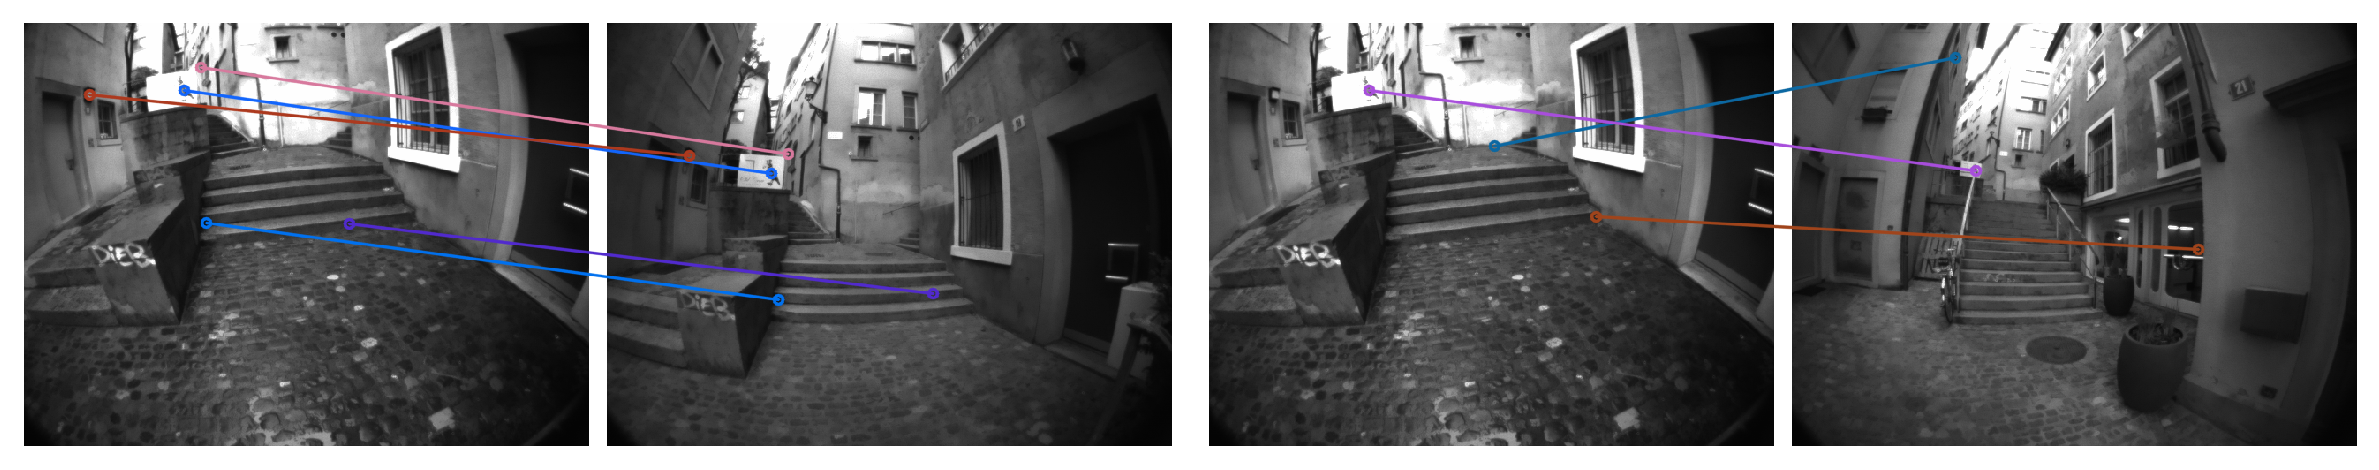

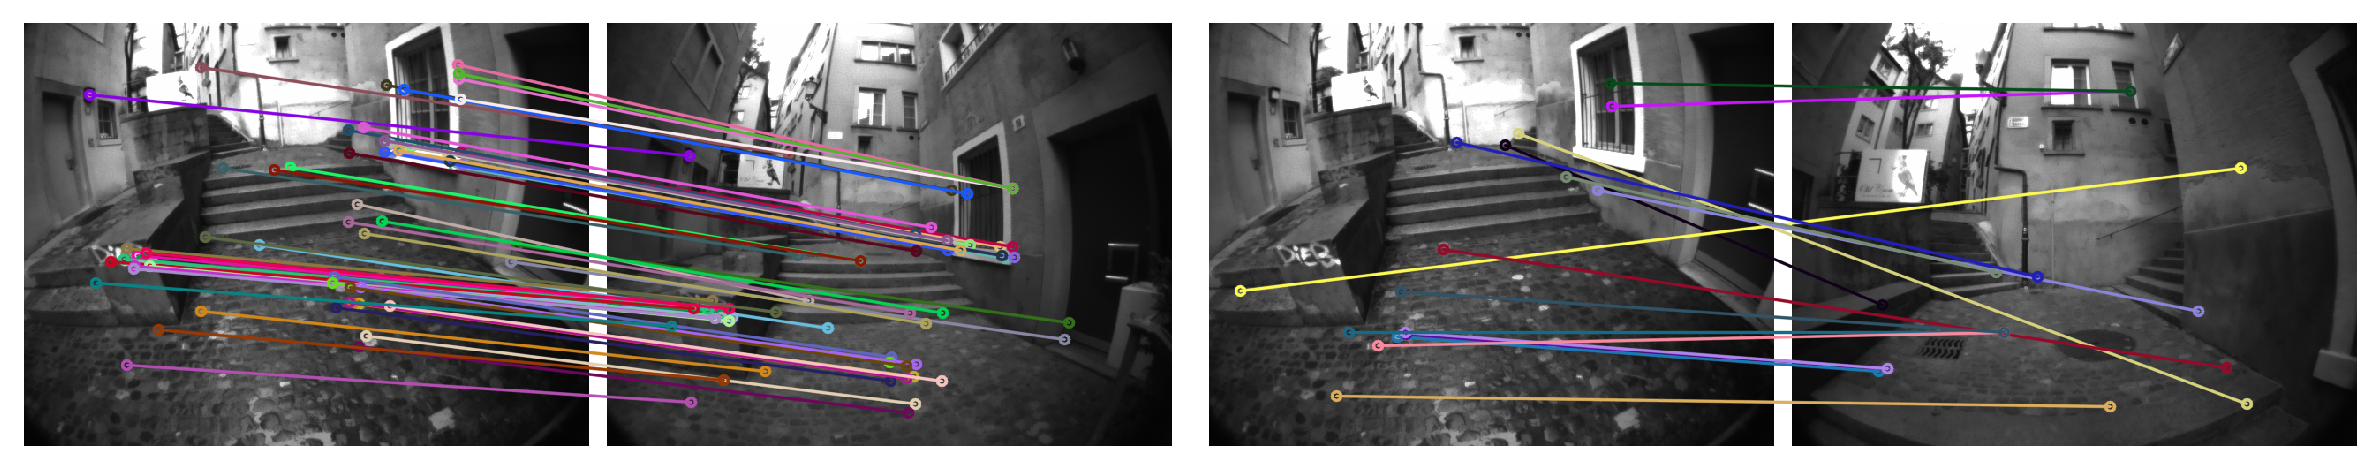

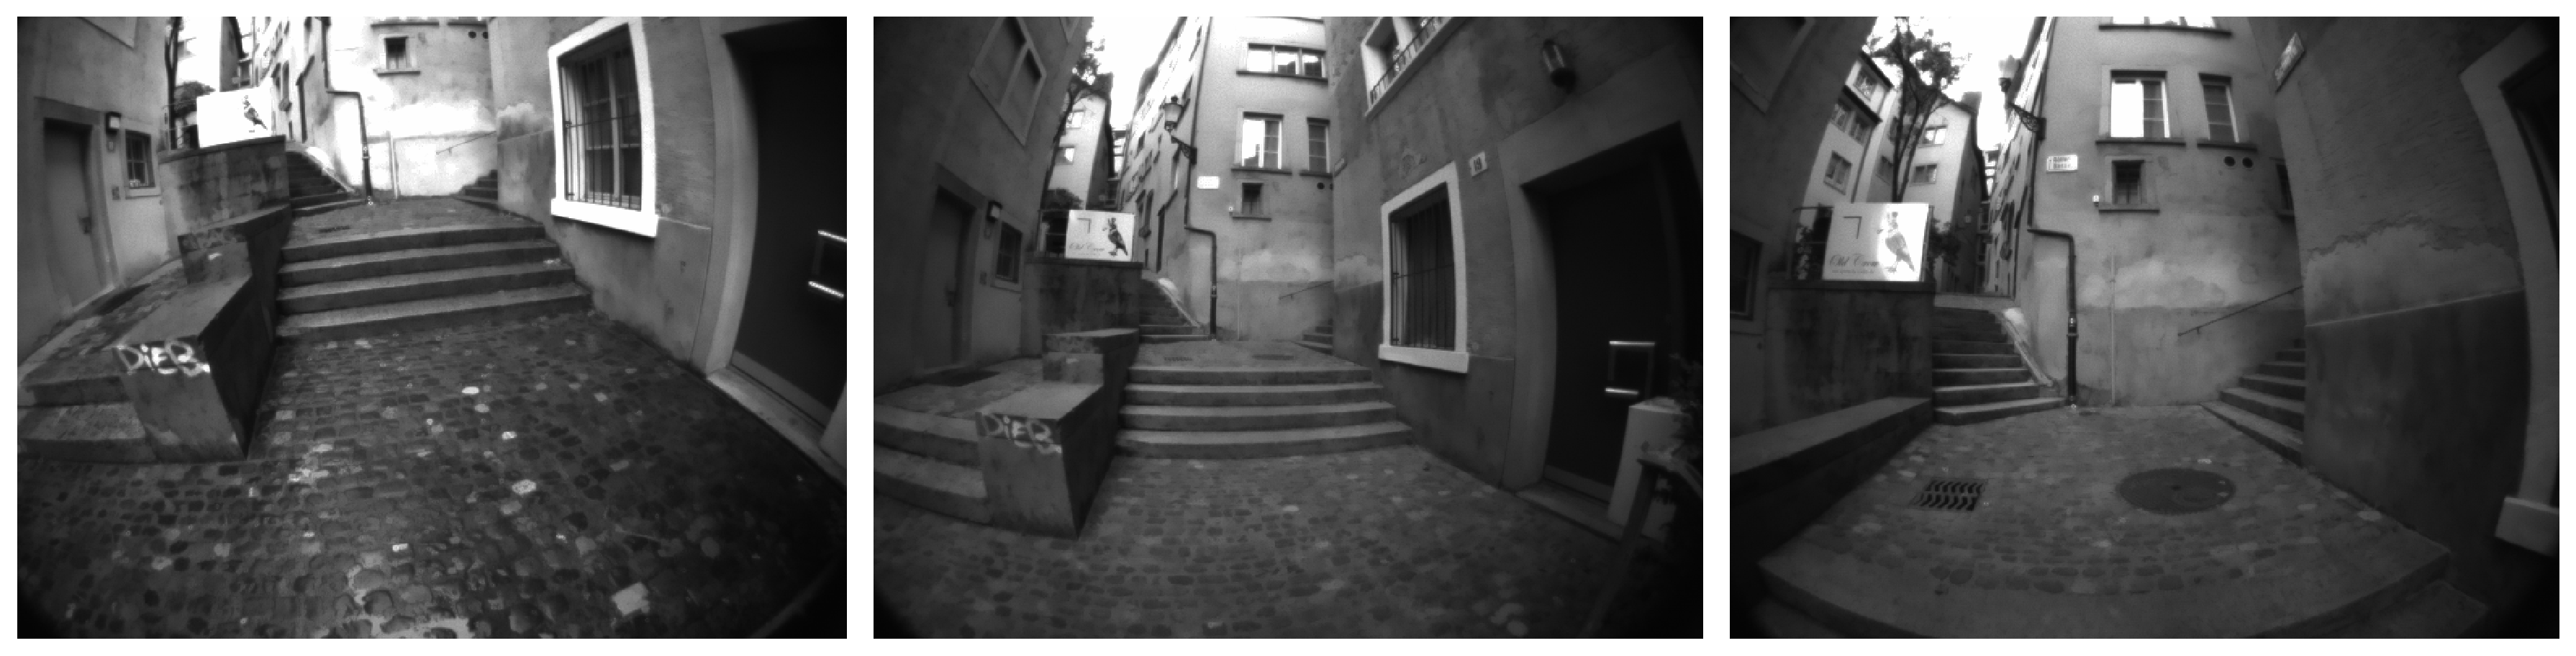

In [31]:
idx = 217
baseline_query = [q for q in baseline_fail_queries if q.query_id == advantage[idx]][0]
fusion_query = [q for q in fusion_ok_queries if q.query_id == advantage[idx]][0]
patches_baseline, _, _ = get_match_patches(baseline_query, 2)
patches_fusion, query_im, retrieved_ims = get_match_patches(fusion_query, 2)

plot_imgs(patches_baseline, dpi=200)
plot_imgs(patches_fusion, dpi=200)
plot_imgs([query_im]+retrieved_ims, dpi=200)

In [32]:
import os
export_path = Path('plots/advantage_{}'.format(idx))
os.mkdir(export_path.as_posix())
for i, p in enumerate(patches_baseline):
    cv2.imwrite(Path(export_path, 'patch_baseline_{}.png'.format(i)).as_posix(), p)
for i, p in enumerate(patches_fusion):
    cv2.imwrite(Path(export_path, 'patch_fusion_{}.png'.format(i)).as_posix(), p)
cv2.imwrite(Path(export_path, 'query.png').as_posix(), query_im)
for i, r in enumerate(retrieved_ims):
    cv2.imwrite(Path(export_path, 'retrieved_{}.png'.format(i)).as_posix(), r)